# Adaptive Solver

This is a short demonstration of the genreralized adaptive solver from:  
J.S. Kottmann, A. Anand, A. Aspuru-Guzik, "A feasible approach for automatically differentiable unitary coupled-cluster on quantum computers".  
See: [doi.org/10.1039/D0SC06627C](https://doi.org/10.1039/D0SC06627C) for more details. 

<img src="pics/adaptive_general.png" alt="Drawing" style="width: 400px;"/>

This tutorial contains the usage for the generalized adaptive solver, it does not discuss the underlying machinery for the fermionic gradients (they are automatically constructed in the background and are used for screening and optimization. See the printouts of the optimizers for information about the expectation values in the objectives and gradients). 

Fore more information about adaptive solvers, we also recommend to look at the original works on adaptive solvers by [Grimsley](https://doi.org/10.1038/s41467-019-10988-2) and [Ryabinkin](https://doi.org/10.1021/acs.jctc.8b00932):

In order to execute this tutorial properly you need to:
- checkout the `devel` branch of tequila (the adapt solver is not yet part of the main branch):  
 `pip install git+https://github.com/aspuru-guzik-group/tequila/tree/devel.git`
- have `qpic` installed to display the circuits: `pip install qpic`

General introduction to `tequila` and it's chemistry modules can be found in separate tutorials:
- Basic usace of `tequila`: [BasicUsage](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/BasicUsage.ipynb)
- Basics with tequila, psi4 and our automatically differentiable framework: [Chemistry.ipynb](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/Chemistry.ipynb)
- Another example for an excited state solver (same principle, less abstraction): [ChemistryExcitedState.ipynb](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/ChemistryExcitedState.ipynb)
- Basics of our basis-set-free `madness` interface, that can be used with the adaptive solvers here as well: [ChemistryMadnessInterface.ipynb](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/ChemistryMadnessInterface.ipynb)

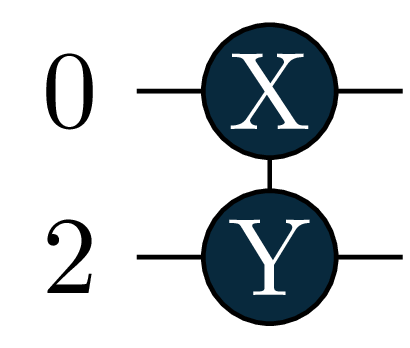

In [15]:
import tequila as tq
import numpy
from IPython.display import Image

# small helper functions to display nicer circuits
def show(circuit, name=None, *args, **kwargs):
    tq.circuit.export_to(circuit, "{}.png".format(name), *args, **kwargs)
    return Image("{}.png".format(name), *args, **kwargs)

# this is how it works
circuit = tq.gates.ExpPauli(paulistring="X(0)Y(2)", angle=1.0)
show(circuit, width=100)

Note that circuits will be represented by their generator in primitive Pauli Rotations so the picture above represents $$e^{-i\frac{\theta}{2} \sigma_x(0) \sigma_y(2)} \equiv e^{-i\frac{\theta}{2} X(0) Y(2)}$$ 

In [2]:
# failsafe
try:
    test = tq.adapt
except:
    print("It seems you have the wrong version of tequila checked out. Please check out the `devel` branch. Or re-install with\npip install git+https://github.com/aspuru-guzik-group/tequila/tree/devel.git")

## A one-qubit example

We start with a simple one-qubit example.  
Of course one would not need an adaptive solver for this, but it executes fast!  

Our circuit will be constructed as in the picture above with:
$$ U_{\text{Pre}} = X $$
$$ U_{\text{Post}} = Y $$

For the adaptive part, we construct an operator pool consisting of the operations:
$$ \text{operator_pool} = \left\{ e^{-i\frac{\theta}{2} X}, e^{-i\frac{\theta}{2} Y}, e^{-i\frac{\theta}{2} Z} \right\} $$
In the code block, the operator_pool is intitialized over it's generators (here: $X,Y,Z$). 

The target will be to minimize the expectation value over $X$:
$$ \min_{\boldsymbol{\theta}} \langle X \rangle_{U_{\text{Post}}U_{\text{Adapt}(\boldsymbol{\theta})}U_{\text{Pre}}}$$

After the adapt solver is intitialized, it can be called. 
The usual keywords for quantum backend and optimizer can be passed at constrution of the solver via `compiler_args={backend="qiskit", samples=1000}` and `optimizer_args={method="bfgs"}`. Note that they are repeated when the solver starts and that the other parameters can be changed as well by just passing name at initialization as `key=value`.


In [3]:
H = tq.paulis.X(0)
Upre = tq.gates.X(0)
Upost = tq.gates.Y(0)
generators = [tq.paulis.Y(0), tq.paulis.Z(0), tq.paulis.X(0)]
operator_pool = tq.adapt.AdaptPoolBase(generators=generators)
solver = tq.adapt.Adapt(H=H, operator_pool=operator_pool, Upre=Upre, UPost=Upost)
result = solver()

Starting Adaptive Solver
optimizer_args                 : {'method': 'bfgs'}
compile_args                   : {}
maxiter                        : 100
energy_convergence             : None
gradient_convergence           : 0.01
max_gradient_convergence       : 0.0
degeneracy_threshold           : 0.0001
operator pool:                 : AdaptPoolBase with 3 Generators
objective factory :            : ObjectiveFactoryBase

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=+0.00000000  angles= {('0', (0, 0)): 0.0}  samples= None
E=-0.84147098  angles= {('0', (0, 0)): 1.0}  samples= None
E=-0.82276010  angles= {('0', (0, 0)): 2.1753425112234144}  samples= None
E=-0.99999951  angles= {('0', (0, 0)): 1.5698029380800227}  samples= None

Here is the final circuit. The result is not very surprising.  
Note that the adaptive solver gives you back the circuit part that was adaptively constructed.  
So in order to get the full circuit with Pre and Post part, you need to assemble it yourself.  
This makes it easiser for cases, where Pre and Post are only used for the optimization.

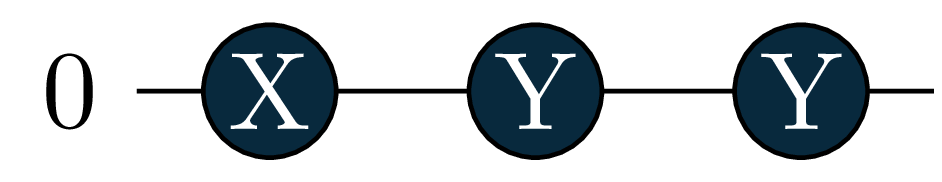

In [4]:
final_circuit = Upre + result.U + Upost
show(final_circuit, width=200)

## A Molecular Ground State

In the following, we employ the adaptive solver for a Molecular ground state, and we use an operator pool with electronic excitation (unitary-coupled cluster primitives). As a toy model we use a simple helium atom since that executes fast in a notebook.

In principle we could use the standard operator_pool from before, and change the generators accordingly (`mol.make_excitation_generator`).  
Is is however better to initialize those gates directly (`mol.make_excitation_gate`), so that tequila can exploit the fermionic information and the optimized gradient framework from [doi.org/10.1039/D0SC06627C](https://doi.org/10.1039/D0SC06627C) can be applied. We refer to the paper and the [BasicUsage](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/BasicUsage.ipynb) tutorial for more information on that.  

In the `MolecularPool` this is automatized. The pool can be constructed by handing spin-orbital indices that describe electronic excitations. One example would be `operator_pool = [((0,2),(1,3)), ((0,2)), ((1,3))]` that holds one double excitation (electrons from spin orbitals 0 and 1 are excited to 2 and 3, and vice versa) and two single excitations. For convenience UpCCGSD style pools can be construced (UpCCD, UpCCSD, UpCCGD, UpCCGSD) by a string keyword. 


Starting Adaptive Solver
optimizer_args                 : {'method': 'bfgs'}
compile_args                   : {}
maxiter                        : 100
energy_convergence             : None
gradient_convergence           : 0.01
max_gradient_convergence       : 0.0
degeneracy_threshold           : 0.0001
operator pool:                 : MolecularPool with 3 Generators
objective factory :            : ObjectiveFactoryBase

Optimizer: <class 'tequila.optimizers.optimizer_scipy.OptimizerSciPy'> 
backend         : qulacs
device          : None
samples         : None
save_history    : True
noise           : None

Method          : BFGS
Objective       : 1 expectationvalues
gradient        : 2 expectationvalues

active variables : 1

E=-2.85516043  angles= {(((0, 2), (1, 3)), (0, 0)): 0.0}  samples= None
E=-2.86211064  angles= {(((0, 2), (1, 3)), (0, 0)): 0.22767215967178345}  samples= None
E=-2.87001868  angles= {(((0, 2), (1, 3)), (0, 0)): 0.1435441028152768}  samples= None
E=-2.87014572  ang

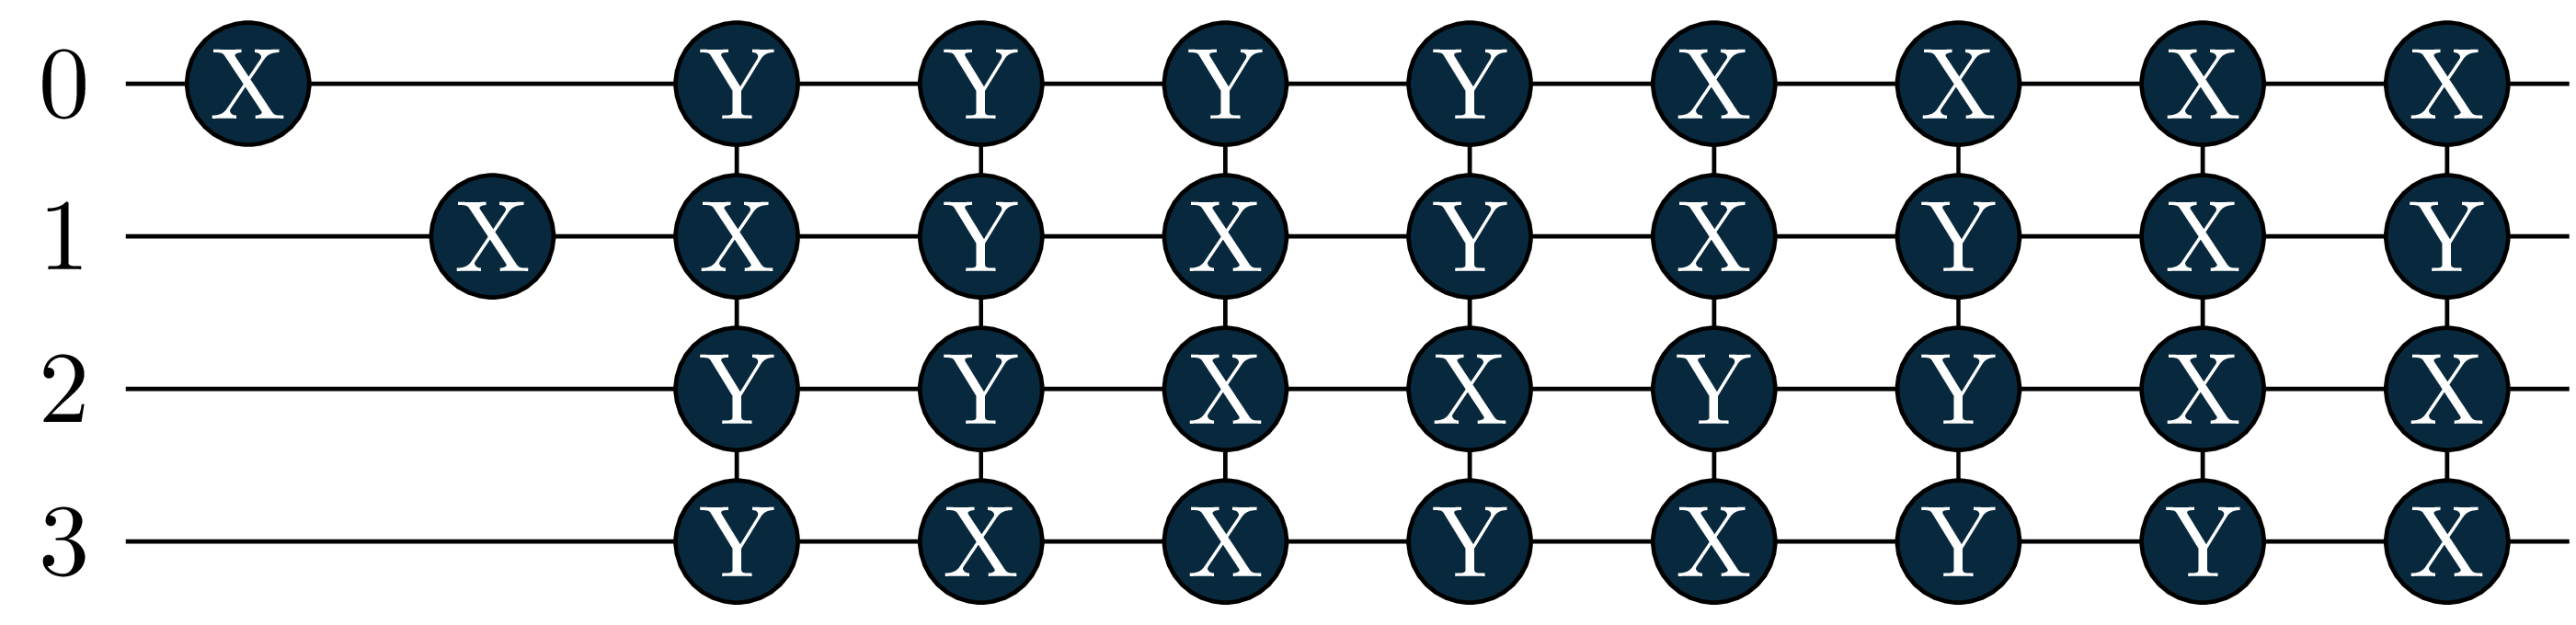

In [5]:
mol = tq.Molecule(geometry="He 0.0 0.0 0.0", basis_set="6-31G")
operator_pool = tq.adapt.MolecularPool(molecule=mol, indices="UpCCSD")
solver = tq.adapt.Adapt(H=mol.make_hamiltonian(), Upre=mol.prepare_reference(), operator_pool=operator_pool)
result = solver(operator_pool=operator_pool, label=0)
final_circuit = mol.prepare_reference() + result.U
show(final_circuit)

## The Same Ground State with fixed Post circuit

The adaptive run before, did not include single excitations (gradients are below the default thresholds for this ground state). Here we add them fixed as Post circuit as an example. You will observe that the energy does not really change through them in this case.

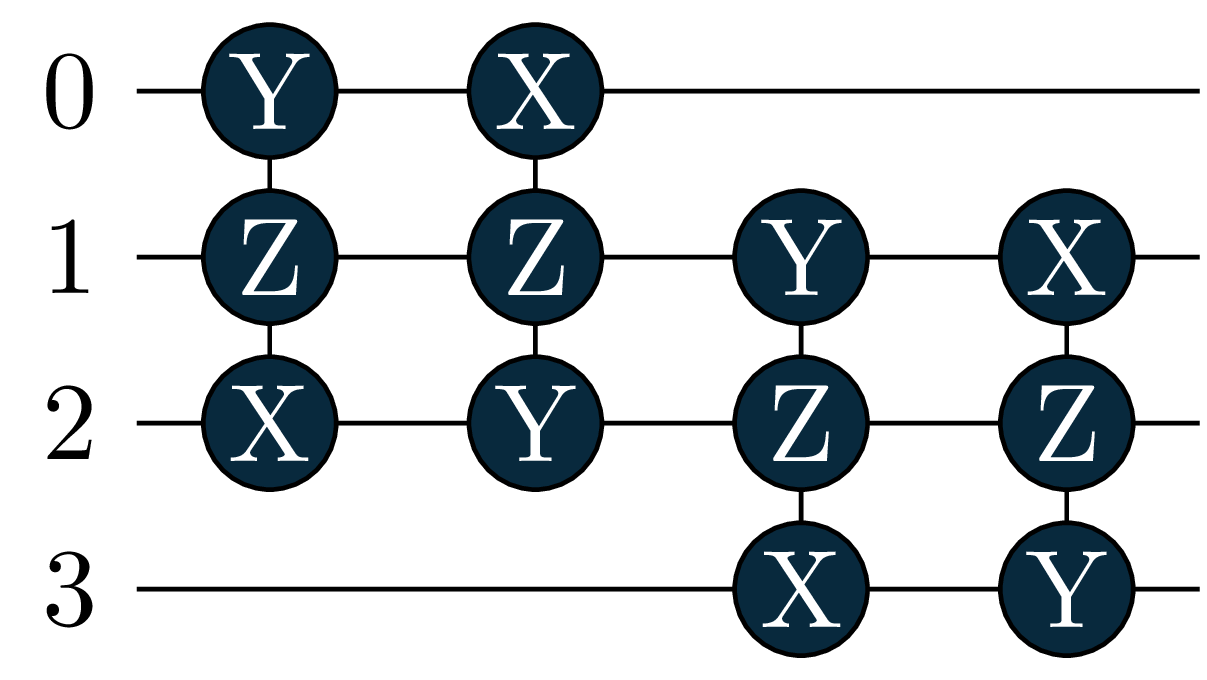

In [6]:
mol = tq.Molecule(geometry="He 0.0 0.0 0.0", basis_set="6-31G")
Upost = mol.make_excitation_gate(angle="a", indices=[(0,2)])
Upost += mol.make_excitation_gate(angle="a", indices=[(1,3)])
show(Upost, width=300)

This Post circuit that we added are single electron excitations that are not all-too important to the Helium ground state, so that the adaptive solver did not include them before. 
As a Pre circuit we will use the Hartree-Fock reference as before.

Note, that we will optimize the parameters "a".  
You can keep them static by passing for example `static_variables={"a":1.0}`.

The default starting value is 0.0, you can change that by passing `variables={"a":1.0}`.

Here, we pass both with `None` (which is the default) to illustrate where they go.

Starting Adaptive Solver
optimizer_args                 : {'method': 'bfgs', 'silent': True}
compile_args                   : {}
maxiter                        : 100
energy_convergence             : None
gradient_convergence           : 0.01
max_gradient_convergence       : 0.0
degeneracy_threshold           : 0.0001
operator pool:                 : MolecularPool with 3 Generators
objective factory :            : ObjectiveFactoryBase



 /home/jsk/projects/OpenVQE/src/tequila/apps/adapt/adapt.py:133: TequilaWarning:variable a of initial objective not given, setting to 0.0 and activate optimization


-------------------------------------
Finished iteration 0
current energy : -2.87016209
difference     : +2.87016209
grad_norm      : +0.22767216
max_grad       : +0.22767216
circuit size   : 1
pool gradient norm is +0.00041087, convergence criterion met


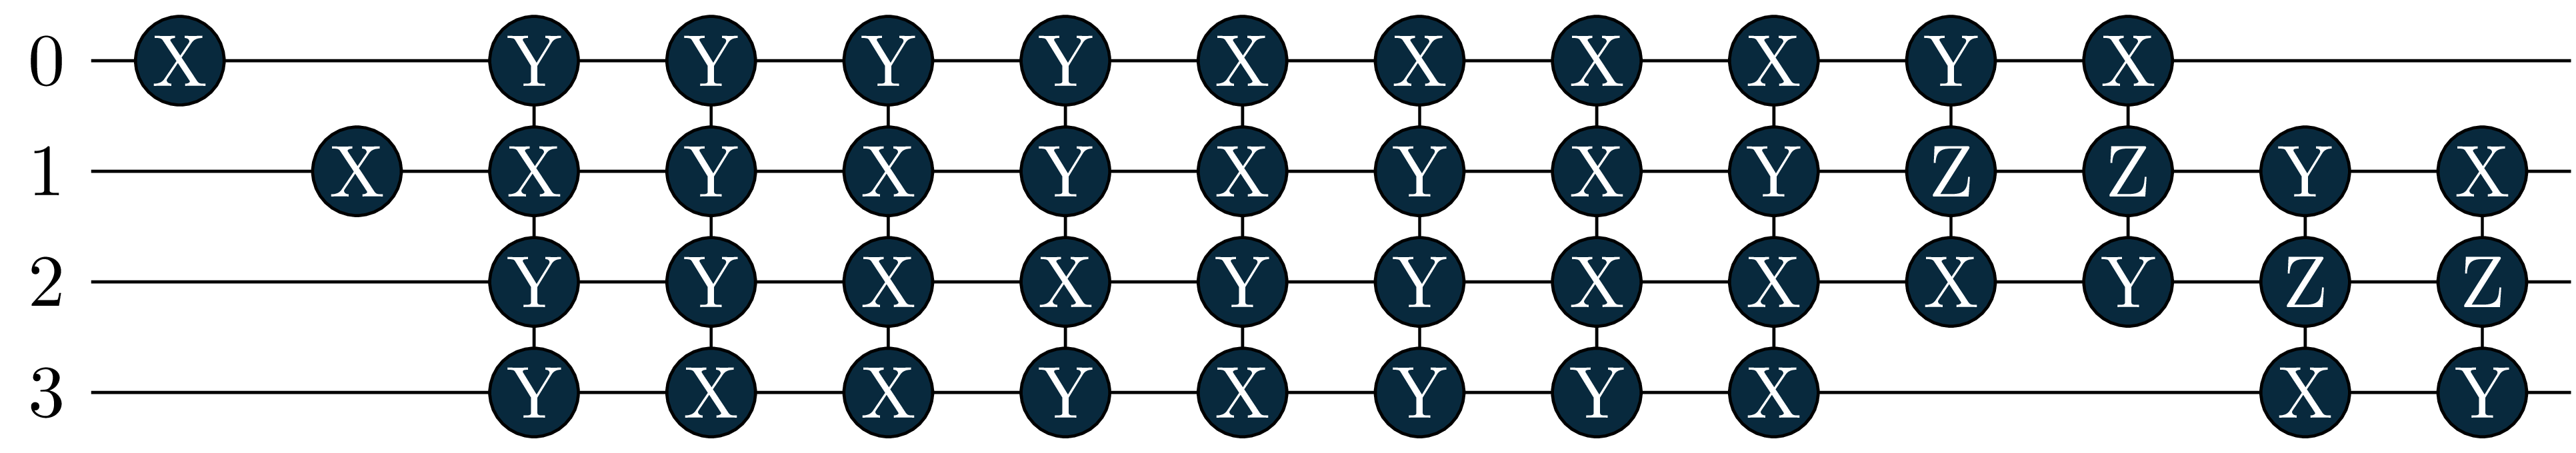

In [7]:
operator_pool = tq.adapt.MolecularPool(molecule=mol, indices="UpCCSD")
solver = tq.adapt.Adapt(H=mol.make_hamiltonian(),
                        Upre=mol.prepare_reference(),
                        Upost=Upost,
                        operator_pool=operator_pool,
                        optimizer_args={"method":"bfgs", "silent":True})
result = solver(operator_pool=operator_pool, label=0, static_variables=None, variables=None)
final_circuit = mol.prepare_reference() + result.U + Upost
show(final_circuit)

## Molecular Ground and Excited States

Finally we compute the first 3 2-electron eigenstates of the molecule.  
We will stay in the 2-electron sector, since our UCC excitations can not break particle symmetry and we are starting with a 2-elecron wavefunction (the Hartree-Fock reference). You can try to change the starting state by replacing `UPre` with any circuit you like. 

In order to compute excited states, we need to minimize a different objective:
$$ O = \langle H \rangle_{U(\theta)} + c \sum_i \langle \mathbf{Q}_+ \rangle_{U_i^{\dagger}U(\theta)}, \quad \mathbf{Q}_+ = \lvert 0\dots0 \rangle \langle 0\dots0 \rvert $$
where $U(\theta)$ is the adaptive circuit and $U_i$ are all the circuits of the states found before. We chose a large number for $c$ instead of the energies of the corresponding state, since the third state will not be bounded (positive energy).

See [doi.org/10.1039/D0SC06627C](https://doi.org/10.1039/D0SC06627C) and it's appendix for a more detailed derivation of the objective, and [ChemistryExcitedState.ipynb](https://github.com/aspuru-guzik-group/tequila-tutorials/blob/main/ChemistryExcitedState.ipynb) for an explicit construction.

Here the objective is constructed automatically in the `ObjectiveFactorySequentialExcitedState` object.  
If you want to create your own objective factory: Just look at the source code of that object. In principle you can pass any object as `objective_factory` that produces a `tequila` objective when given a `tequila` circuit. This is also how it is used within the adapt solver.


In [8]:
mol = tq.Molecule(geometry="He 0.0 0.0 0.0", basis_set="6-31G")
operator_pool = tq.adapt.MolecularPool(molecule=mol, indices="UpCCSD")


circuits = []
variables = {}
for state in range(3):
    print("\nStarting optimization of state {}".format(state))
    Upre = mol.prepare_reference()
    operator_pool = tq.adapt.MolecularPool(molecule=mol, indices="UpCCSD")
    objective_factory = tq.adapt.ObjectiveFactorySequentialExcitedState(Upre=mol.prepare_reference(), H=mol.make_hamiltonian(), circuits=circuits, factors=[100.0]*len(circuits))
    solver = tq.adapt.Adapt(objective_factory=objective_factory,
                                   Upre=mol.prepare_reference(),
                                   operator_pool=operator_pool,
                                   optimizer_args={"method":"bfgs", "silent":True})
    result = solver(operator_pool=operator_pool, label=state, static_variables=variables)
    U = Upre + result.U
    circuits.append(U)
    variables = {**variables, **result.variables}


Starting optimization of state 0
Starting Adaptive Solver
optimizer_args                 : {'method': 'bfgs', 'silent': True}
compile_args                   : {}
maxiter                        : 100
energy_convergence             : None
gradient_convergence           : 0.01
max_gradient_convergence       : 0.0
degeneracy_threshold           : 0.0001
operator pool:                 : MolecularPool with 3 Generators
objective factory :            : ObjectiveFactorySequentialExcitedState

-------------------------------------
Finished iteration 0
current energy : -2.87014572
difference     : +2.87014572
grad_norm      : +0.22767216
max_grad       : +0.22767216
circuit size   : 1
pool gradient norm is +0.00597687, convergence criterion met

Starting optimization of state 1
Starting Adaptive Solver
optimizer_args                 : {'method': 'bfgs', 'silent': True}
compile_args                   : {}
maxiter                        : 100
energy_convergence             : None
gradient_converg

Let's take a look at the states we found:

In [9]:
H = mol.make_hamiltonian()
for U in circuits:
    energy = tq.simulate(tq.ExpectationValue(H=H, U=U), variables=variables)
    wfn = tq.simulate(U, variables=variables)
    print("energy = {:+2.4f}, wfn=".format(energy), wfn)

energy = -2.8701, wfn= +0.9978|1100> -0.0657|0011> 
energy = -0.9487, wfn= +0.0036|1100> -0.7060|0110> +0.7060|1001> +0.0555|0011> 
energy = +0.6086, wfn= +0.0656|1100> +0.0393|0110> -0.0393|1001> +0.9963|0011> 


Lets diagonalize the Hamiltonion with numpy and check if we really found eigenstates
We will only display states that have overlap with our reference wavefunctio ($\lvert110000....0\rangle = \lvert 2^{N_q -1} + 2^{N_q -2} \rangle$)  
in order to not have too much output here

In [10]:
eigenvalues, eigenvectors = numpy.linalg.eigh(H.to_matrix())
n_qubits = H.n_qubits
reference_basis_state = 2**(n_qubits-1) + 2**(n_qubits-2)
print("total states: {}".format(len(eigenvalues)))
print("states of interest:")
for i in range(len(eigenvalues)):
    if not numpy.isclose(eigenvectors[:,i][reference_basis_state], 0.0, atol=1.e-4):
        print("energy = {:2.4f}, wfn = ".format(eigenvalues[i]), tq.QubitWaveFunction(eigenvectors[:,i]))

total states: 16
states of interest:
energy = -2.8702, wfn =  -0.0657|0011> +0.0021|0110> -0.0021|1001> +0.9978|1100> 
energy = -0.9487, wfn =  +0.0550|0011> -0.7060|0110> +0.7060|1001> +0.0065|1100> 
energy = 0.6086, wfn =  -0.9963|0011> -0.0391|0110> +0.0391|1001> -0.0655|1100> 


Let's also look at the circuits:
The singles became more important in the excited states, and where added by the adaptive solver!

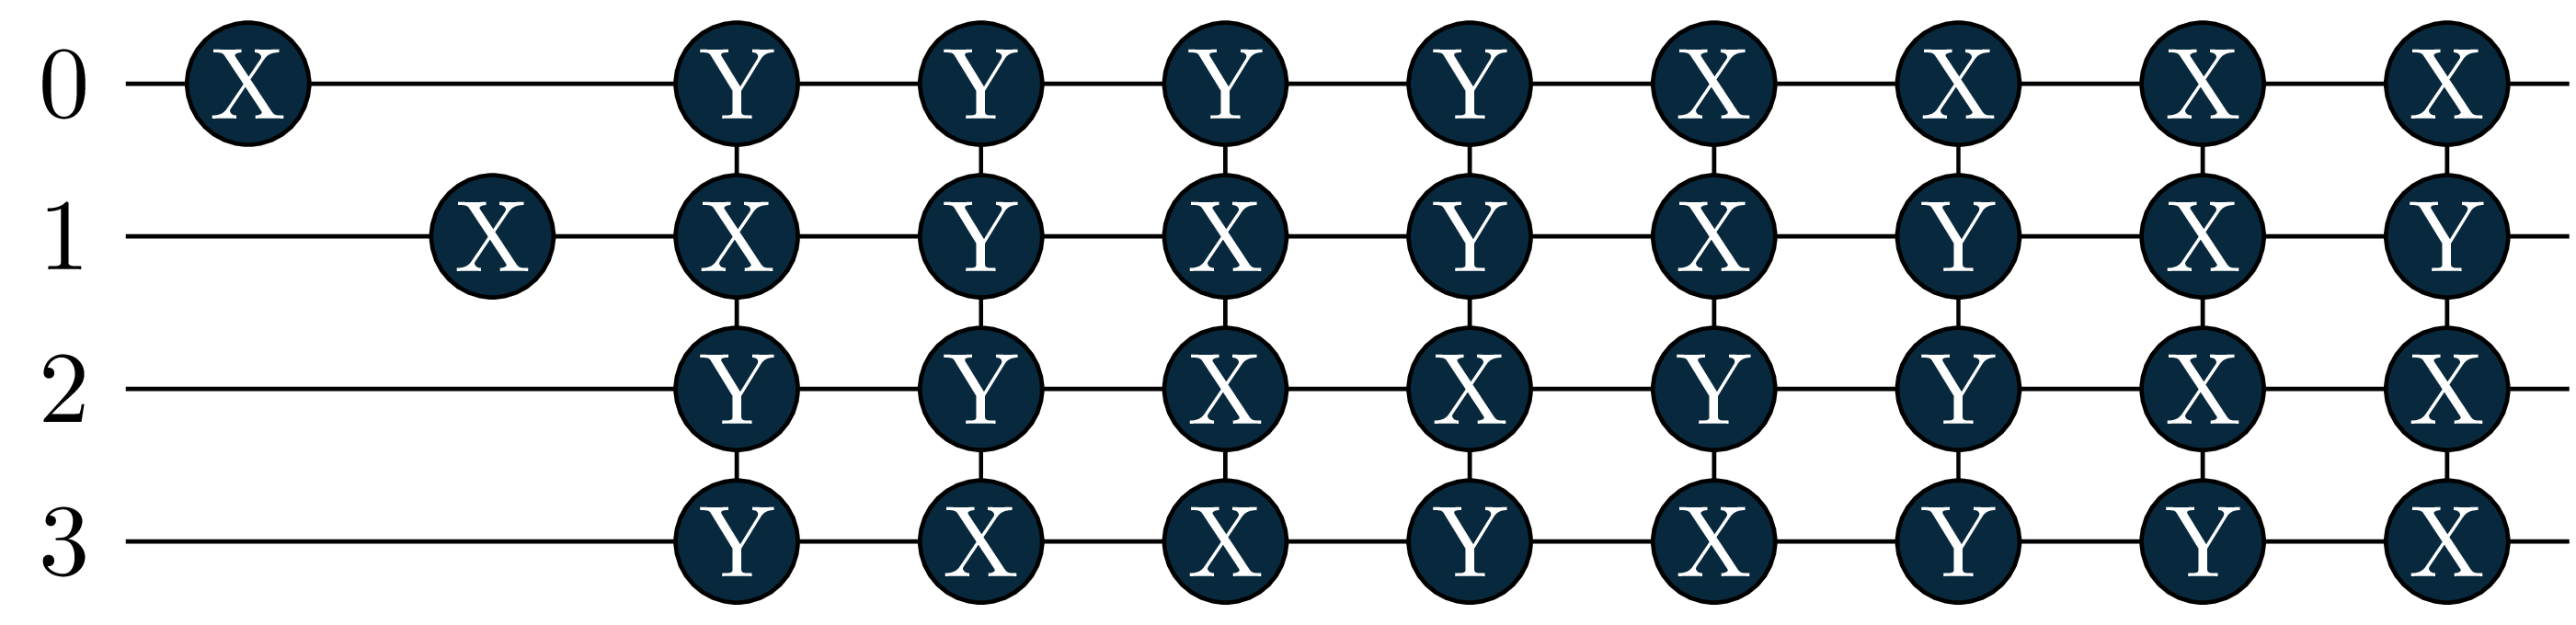

In [11]:
show(circuits[0])

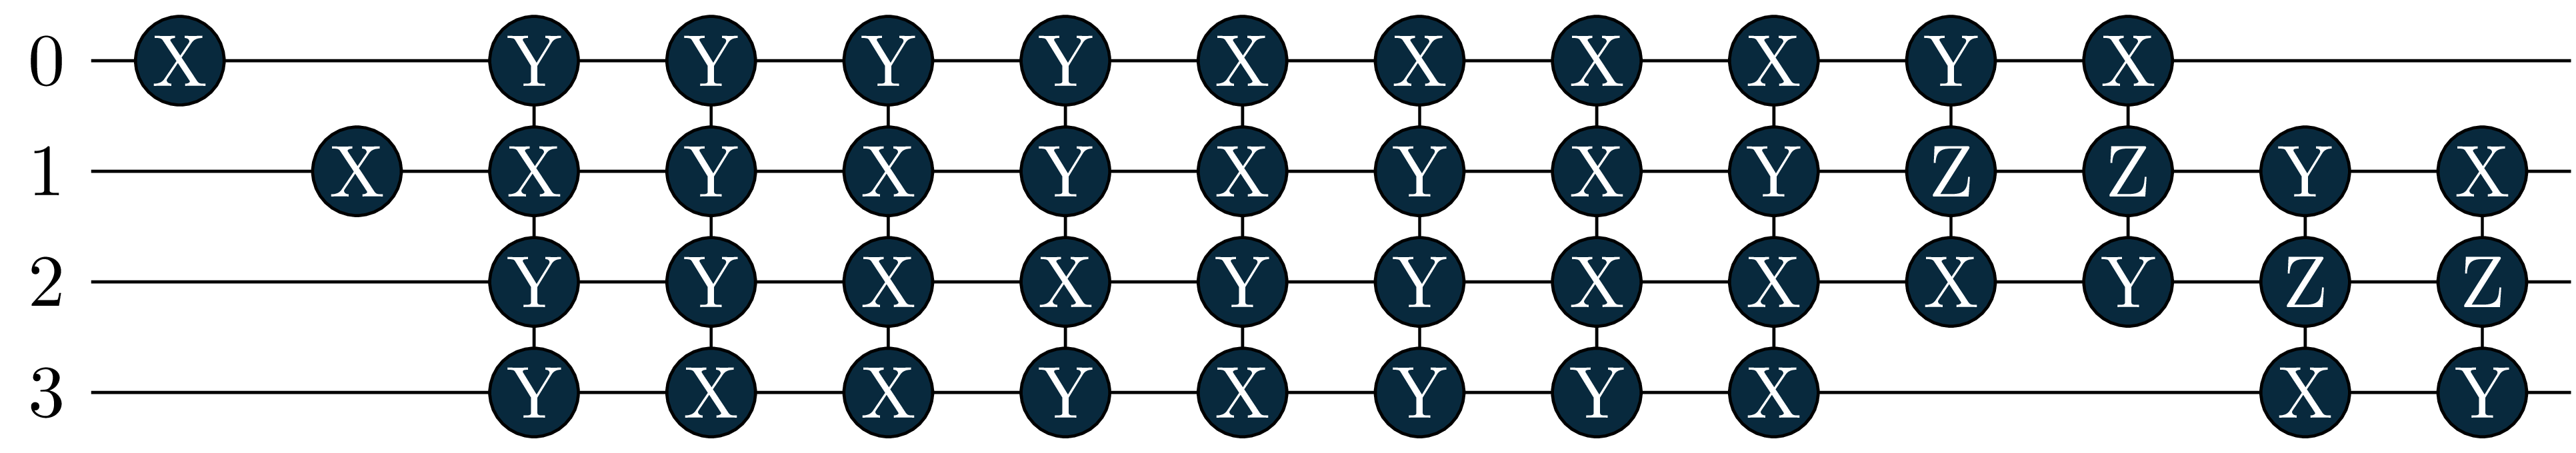

In [12]:
show(circuits[1])

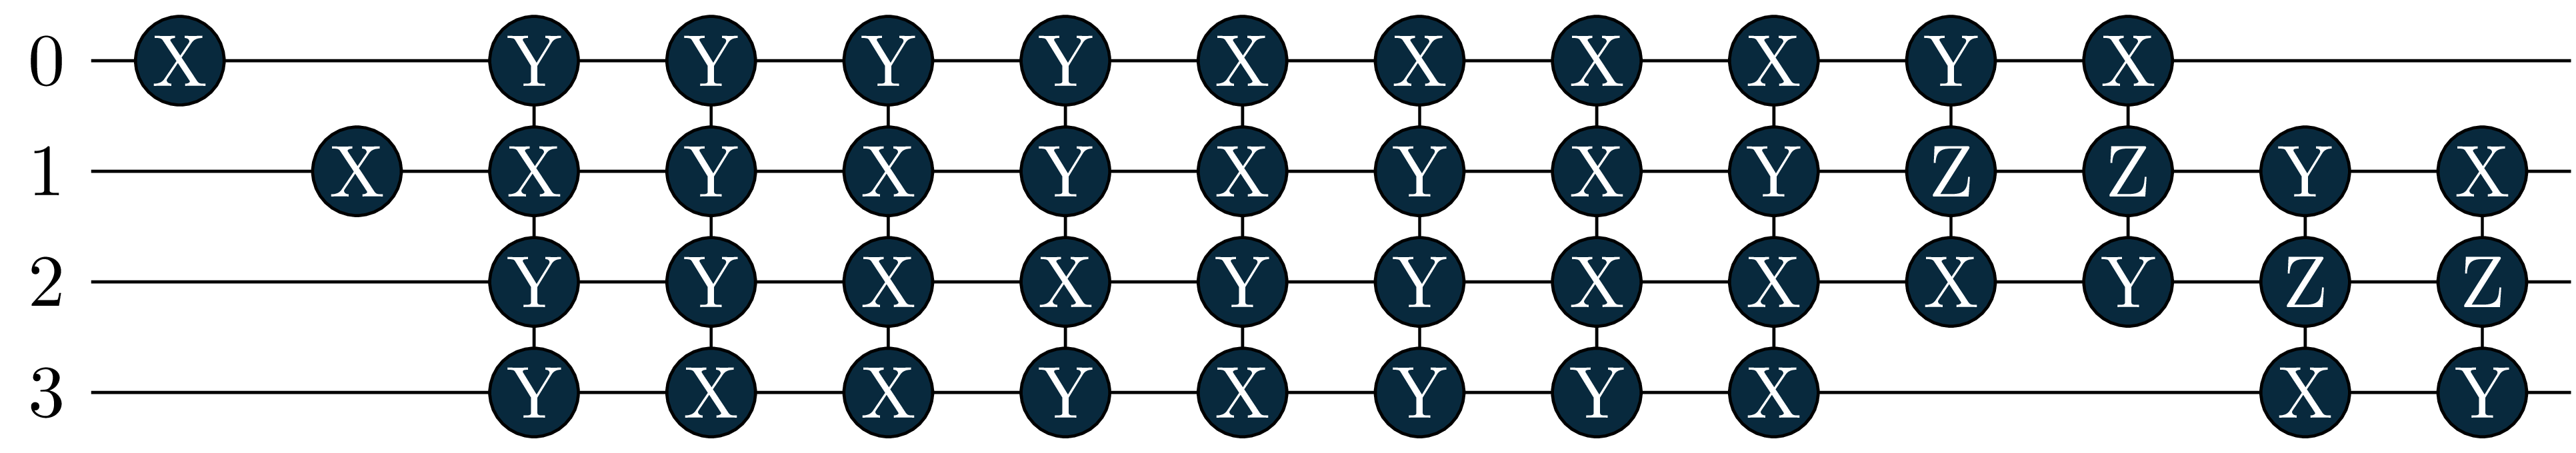

In [13]:
show(circuits[2])

## Acceleration with multiprocessing

You can speed up the screening procedure with multiprocessing (not hoewever, that depending on which backend it is, the quantum backend will also use multiprocessing -- so it is adviced to balance the multiprocessing worker threads with `OMP_NUM_THREADS`). Here is the last example with multiprocessing and 2 threads. Note that you need to create a `Psi4` independent molecule object in order to make it suitable for multiprocessing.  

We advice not to execute the cell in a jupyter notebook!

In [14]:
if False: # let's not execute this here
    import tequila as tq
    import multiprocessing as mp

    mp_pool = mp.Pool(2)

    mol = tq.Molecule(geometry="He 0.0 0.0 0.0", basis_set="6-31G")

    # decouple from psi4 (psi4 molecules can not be pickled)
    mol = tq.chemistry.MoleculeFromOpenFermion(mol.molecule)

    operator_pool = tq.adapt.MolecularPool(molecule=mol, indices="UpCCSD")


    circuits = []
    variables = {}
    for state in range(3):
        print("\nStarting optimization of state {}".format(state))
        Upre = mol.prepare_reference()
        operator_pool = tq.adapt.MolecularPool(molecule=mol, indices="UpCCSD")
        objective_factory = tq.adapt.ObjectiveFactorySequentialExcitedState(Upre=mol.prepare_reference(), H=mol.make_hamiltonian(), circuits=circuits, factors=[100.0]*len(circuits))
        solver = tq.adapt.Adapt(objective_factory=objective_factory,
                                       Upre=mol.prepare_reference(),
                                       operator_pool=operator_pool,
                                       optimizer_args={"method":"bfgs", "silent":True})
        result = solver(operator_pool=operator_pool, label=state, static_variables=variables, mp_pool=mp_pool)
        U = Upre + result.U
        circuits.append(U)
        variables = {**variables, **result.variables}

    mp_pool.close()
    mp_pool.join()